# Problem 2 - Implementing a Softmax Classifer

### Part 1

In [1]:
import numpy as np
from random import shuffle
from sklearn import preprocessing

In [2]:
# Function to load data
def load_data(path):
    data = np.loadtxt(path)
    return data[:, 0], data[:, 1:]

In [3]:
iris_train_labels, iris_train_data = load_data("iris-train.txt")
iris_test_labels, iris_test_data = load_data("iris-test.txt")

In [4]:
# One-hot function to make the labels into one-hot vector
def iris_one_hot(labels):
    one_hot_labels = np.zeros((len(labels), 3))
    for i in range(len(labels)):
        one_hot_labels[i][int(labels[i]) - 1] = 1
    return one_hot_labels

In [5]:
# Function to normalize the features of the data
def normalize(train_data, test_data):
    # normalize between -1 and 1 with minmaxscaler
    scaler = preprocessing.MinMaxScaler(feature_range = (-1, 1))
    train_data_nor = scaler.fit_transform(train_data)
    test_data_nor = scaler.transform(test_data)
    return train_data_nor, test_data_nor

In [6]:
# Function to normalize the features of the data
def normalize_2(train_data, test_data):
    # normalize between -1 and 1 with minmaxscaler
    return 2 * (train_data - 0.5), 2 * (test_data - 0.5)

In [7]:
# Forward pass function
def forward(x, weight):
    return np.dot(np.array(x), np.array(weight))

In [8]:
# Softmax function
def softmax(output_list):
    exp_output_list = np.exp(output_list - np.max(output_list))
    return exp_output_list/(np.sum(exp_output_list, axis = 1, keepdims = True) + 1e-15)

In [9]:
# Cross-entropy loss Function
def cross_entropy(data, pred, true_labels, weights, l2_weight_decay_factor):
    # With L2 regularization
    data = np.stack(data, axis=0)
    loss = np.sum((- np.array(true_labels) * np.log(pred + 1e-15)))/len(true_labels) + l2_weight_decay_factor * np.linalg.norm(weights, 2)/2
    loss_grad = pred.copy()
    loss_grad = loss_grad - true_labels
    loss_grad = np.dot(data.T, loss_grad)
    loss_grad = loss_grad/len(true_labels)
    return loss, loss_grad

In [10]:
# Function to compute mean per-class accuracy
def computeMPC(pred, true_labels):
    prediction = np.zeros_like(pred)
    prediction[np.arange(len(pred)), pred.argmax(1)] = 1
    return np.sum(~(true_labels - prediction).any(1))/len(pred)

In [11]:
# Function to do stochastic gradient descent with mini-batches and momentum
def single_stochastic_gradient(train_data, train_labels, test_data, test_labels, weights, mini_batch_size, learning_rate, momentum_rate, l2_weight_decay_factor):
    train_zip = list(zip(train_data, train_labels))
    shuffle(train_zip)
    train_data_shuff, train_labels_shuff = zip(*train_zip)
    
    test_zip = list(zip(test_data, test_labels))
    shuffle(test_zip)
    test_data_shuff, test_labels_shuff = zip(*test_zip)
    
    iter_num = len(train_data)//mini_batch_size
    prev_grad = 0
    
    loss = 0
    for i in range(iter_num):
        new_pred = forward(train_data_shuff[i * mini_batch_size:(i + 1) * mini_batch_size], weights)
        new_p = softmax(new_pred)
        new_loss, new_loss_grad = cross_entropy(train_data_shuff[i * mini_batch_size:(i + 1) * mini_batch_size], new_p, train_labels_shuff[i * mini_batch_size:(i + 1) * mini_batch_size], weights, l2_weight_decay_factor)
        loss = loss + new_loss
        # Find new weights
        weights = weights - momentum_rate * prev_grad - learning_rate * new_loss_grad
        prev_grad = new_loss_grad
        
    # For training data
    new_pred = forward(train_data_shuff, weights)
    new_p = softmax(new_pred)
    epoch_acc = computeMPC(new_p, train_labels_shuff)
    # For testing data
    test_new_pred = forward(test_data_shuff, weights)
    test_new_p = softmax(test_new_pred)
    test_loss, _ = cross_entropy(test_data_shuff, test_new_p, test_labels_shuff, weights, l2_weight_decay_factor)
    test_epoch_acc = computeMPC(test_new_p, test_labels_shuff)
    return epoch_acc, test_epoch_acc, weights, loss/iter_num, test_loss

In [12]:
# Returns the learned weights, the mean per class accuracy for each epoch for train and test,
# loss for each epoch for train and test
def train_softmax(train_data, train_labels, test_data, test_labels, weights, mini_batch_size, learning_rate, momentum_rate, l2_weight_decay_factor, num_epochs):
    epoch_acc_list = []
    test_epoch_acc_list = []
    loss_list = []
    test_loss_list = []
    for i in range(num_epochs):
        epoch_acc, test_epoch_acc, weights, loss, test_loss = single_stochastic_gradient(train_data, train_labels, test_data, test_labels, weights, mini_batch_size, learning_rate, momentum_rate, l2_weight_decay_factor)
        epoch_acc_list.append(epoch_acc)
        test_epoch_acc_list.append(test_epoch_acc)
        loss_list.append(loss)
        test_loss_list.append(test_loss)
    return epoch_acc_list, test_epoch_acc_list, weights, loss_list, test_loss_list

In [13]:
# Function to create the single layer neural network for softmax classifier
def main_iris(train_file_path, test_file_path, param, num_epochs = 1000):
    # param = (Mini-batch size, learning rate, momentum rate, and L2 weight decay factor)
    mini_batch_size, learning_rate, momentum_rate, l2_weight_decay_factor = param
    
    iris_train_labels, iris_train_data = load_data(train_file_path)
    iris_test_labels, iris_test_data = load_data(test_file_path)
    iris_train_data_normalized, iris_test_data_normalized = normalize(iris_train_data, iris_test_data)
    iris_train_labels_hot = iris_one_hot(iris_train_labels)
    iris_test_labels_hot = iris_one_hot(iris_test_labels)
    
    # Initialize random weights
    weights = np.random.random((2,3))
    
    epoch_acc_list, test_epoch_acc_list, weights, loss_list, test_lost_list = train_softmax(iris_train_data_normalized, iris_train_labels_hot, iris_test_data_normalized, iris_test_labels_hot, weights, mini_batch_size, learning_rate, momentum_rate, l2_weight_decay_factor, num_epochs)
    
    return epoch_acc_list, test_epoch_acc_list, weights, loss_list, test_lost_list

In [14]:
# Adjusting the hyperparam manually
# (Mini-batch size, learning rate, momentum rate, and L2 weight decay factor)
param = (10, 0.01, 0.005, 0.10)
epoch_acc_list, test_epoch_acc_list, weights, loss_list, test_loss_list = main_iris("iris-train.txt", "iris-test.txt", param, 1000)

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

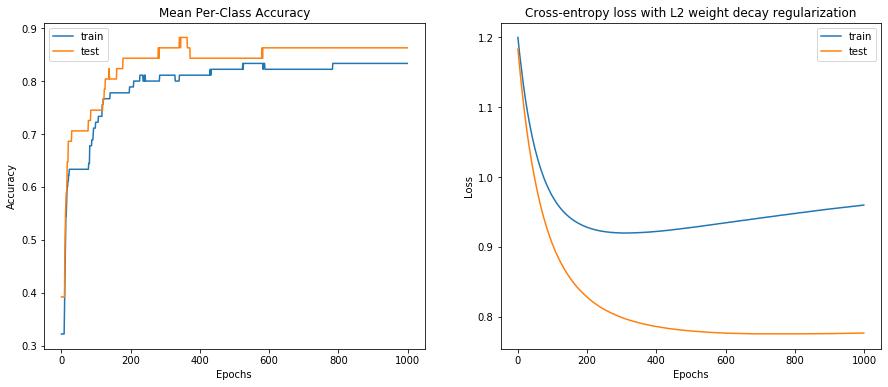

In [16]:
f, (ax1, ax2) = plt.subplots(1, 2)
f.set_figheight(6)
f.set_figwidth(15)
_ = ax1.plot(np.arange(len(epoch_acc_list)), epoch_acc_list)
_ = ax1.plot(np.arange(len(test_epoch_acc_list)), test_epoch_acc_list)
_ = ax1.legend(['train', 'test'])
_ = ax1.set_title("Mean Per-Class Accuracy")
_ = ax1.set_xlabel("Epochs")
_ = ax1.set_ylabel("Accuracy")

_ = ax2.plot(np.arange(len(loss_list)), loss_list)
_ = ax2.plot(np.arange(len(loss_list)), test_loss_list)
_ = ax2.legend(['train', 'test'])
_ = ax2.set_title("Cross-entropy loss with L2 weight decay regularization")
_ = ax2.set_xlabel("Epochs")
_ = ax2.set_ylabel("Loss")

In [17]:
weights

array([[-0.80620931,  1.23603275,  0.97700969],
       [-3.28893015,  1.5392253 ,  4.23647836]])

In [18]:
max(test_epoch_acc_list)

0.8823529411764706

### Part 2

In [19]:
import matplotlib.patches as mps

In [20]:
# Load data
iris_train_labels, iris_train_data = load_data("iris-train.txt")
iris_test_labels, iris_test_data = load_data("iris-test.txt")
iris_train_data_normalized, iris_test_data_normalized = normalize(iris_train_data, iris_test_data)

In [21]:
# Create grid
x, y = np.meshgrid(np.arange(-1.2, 1.2, 0.01), np.arange(-1.2, 1.2, 0.01))
all_coor = np.c_[x.ravel(), y.ravel()]

# Predict
train_pred = softmax(forward(all_coor, weights))
train_p = train_pred.argmax(1)
pic_p = train_p.reshape(x.shape)

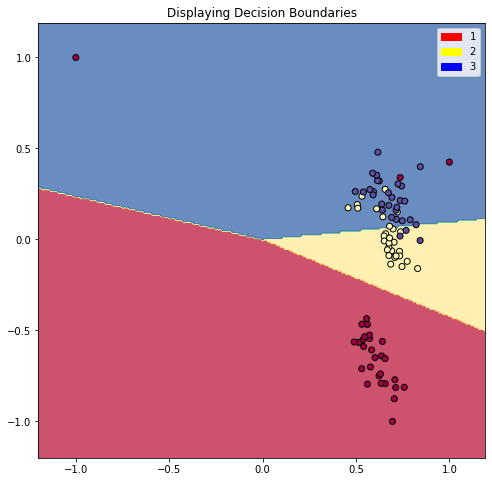

In [22]:
_ = plt.figure(figsize = (8, 8))
_ = plt.contourf(x, y, pic_p, cmap = plt.cm.Spectral, alpha = 0.8)
patch_1 = mps.Patch(color = 'red', label='1')
patch_2 = mps.Patch(color = 'yellow', label='2')
patch_3 = mps.Patch(color = 'blue', label='3')
_ = plt.legend(handles=[patch_1, patch_2, patch_3])
_ = plt.scatter(iris_train_data_normalized[:,0], iris_train_data_normalized[:,1], c = iris_train_labels, cmap = plt.cm.Spectral, edgecolor='k')
_ = plt.title("Displaying Decision Boundaries")